## set running directory

In [1]:
from __future__ import print_function
import os
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

In [2]:
from pkg.controller.combined_robot import *
from pkg.utils.utils import get_now, try_mkdir


DATA_PATH = os.path.join(os.environ['RNB_PLANNING_DIR'], "data")
try_mkdir(DATA_PATH)

ALG_DATA_PATH = os.path.join(DATA_PATH, "latticized")
try_mkdir(ALG_DATA_PATH)

In [3]:
VISUALIZE = False
TIMEOUT_REACH = 30
TIMEOUT_RETRIEVE = 30
CLEARANCE = 1e-3

ROBOT_TYPE = RobotType.indy7
ROBOT_NAME = "indy0"
TOOL_LINK = "indy0_tcp"
TOOL_LINK_BUNDLE = ["indy0_tcp", "indy0_link6"]
TOOL_XYZ = (0,0,0.14)
TOOL_RPY = (-np.pi/2,0,0)
GRIP_DEPTH = 0.05
HOME_POSE = (0,0,0,0,0,0)

# ROBOT_TYPE = RobotType.panda
# ROBOT_NAME = "panda0"
# TOOL_LINK = "panda0_hand"
# TOOL_LINK_BUNDLE = ["panda0_hand", "panda0_link6"]
# TOOL_XYZ = (0,0,0.112)
# TOOL_RPY = (-np.pi/2,0,0)
# GRIP_DEPTH = 0.03
# HOME_POSE = (0,-0.3,0,-0.5,0,2.5,0)


assert TOOL_LINK_BUNDLE[0] == TOOL_LINK, "TOOL_LINK_BUNDLE should be in reverse order including actor's link as the first item"

## init combined robot config

In [4]:

from pkg.project_config import *

crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, ROBOT_TYPE, None,
                INDY_IP)]
              , connection_list=[False])

connection_list
[False]


In [5]:
from pkg.geometry.builder.scene_builder import SceneBuilder
s_builder = SceneBuilder(None, base_link="base_link")
# s_builder.reset_reference_coord(ref_name="floor")

## get ghnd with detected robot config

In [6]:
# xyz_rpy_robots = s_builder.detect_items(level_mask=[DetectionLevel.ROBOT])
xyz_rpy_robots = {ROBOT_NAME: ((0,0,0), (0,0,0))}
crob.update_robot_pos_dict(xyz_rpy_robots=xyz_rpy_robots)
gscene = s_builder.create_gscene(crob, start_rviz=VISUALIZE)
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)


Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


In [7]:
from pkg.utils.joint_utils import get_tf
shoulder_link = gscene.urdf_content.joint_map[gscene.joint_names[1]].child
shoulder_height = get_tf(shoulder_link, HOME_DICT, gscene.urdf_content)[2,3]

## add environment

In [8]:
from pkg.geometry.geometry import *

In [9]:
gtems_robot = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)

## init planning scene

In [10]:
from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

## Register binders

In [11]:
from pkg.planning.constraint.constraint_actor import Gripper2Tool, PlacePlane, SweepTool

In [12]:
gscene.create_safe(gtype=GEOTYPE.SPHERE, name="grip0", link_name=TOOL_LINK, 
                 dims=(0.01,)*3, center=TOOL_XYZ, rpy=TOOL_RPY, color=(1,0,0,1), display=True, collision=False, fixed=True)
gripper = pscene.create_binder(bname="grip0", gname="grip0", rname=ROBOT_NAME, _type=Gripper2Tool, point=(0,0,0), rpy=(0,0,0))

## planner

In [13]:
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
from pkg.planning.filtering.reach_filter import ReachChecker
mplan = MoveitPlanner(pscene)
gcheck = GraspChecker(pscene, end_link_couple_dict= {TOOL_LINK: TOOL_LINK_BUNDLE, "base_link":["base_link"]})
rcheck = ReachChecker(pscene)
checkers = [gcheck, rcheck]

## ui

In [14]:
from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


# Object Classes

In [15]:
from pkg.utils.gjk import get_point_list, get_gjk_distance
from pkg.planning.constraint.constraint_subject import CustomObject, Grasp2Point, PlacePoint, SweepPoint, SweepTask

##
# @class ObstacleBase
# @brief base class for obstacle generators
class ObstacleBase:
    RTH_MIN = None ## R: center ~ nearest point
    RTH_MAX = None
    RPY_MIN = None
    RPY_MAX = None
    DIM_MIN = None
    DIM_MAX = None
    GTYPE = None
    COLOR = (0.7,0.7,0.7,1)
    
    def __init__(self, gscene, name, sampler=np.random.uniform, DIM=None, RTH=None, RPY=None):
        self.name = name
        self.DIM = sampler(self.DIM_MIN, self.DIM_MAX) if DIM is None else DIM
        self.RTH = sampler(self.RTH_MIN, self.RTH_MAX) if RTH is None else RTH
        self.RPY = sampler(self.RPY_MIN, self.RPY_MAX) if RPY is None else RPY
        self.RPY[2] += self.RTH[1]
        self.XYZ = np.array(cyl2cart(*self.RTH))
        verts_rotated = np.matmul(Rot_rpy(self.RPY), (DEFAULT_VERT_DICT[self.GTYPE]*self.DIM).transpose())
        xy_normed = self.XYZ[:2]/(np.linalg.norm(self.XYZ[:2])+1e-6)
        verts_r_compo = np.dot(xy_normed, verts_rotated[:2,:])
        self.XYZ[:2] -= xy_normed[:2]*np.min(verts_r_compo)
        self.RTH[0] -= np.min(verts_r_compo)
        self.geometry = gscene.create_safe(gtype=self.GTYPE, name=self.name, link_name="base_link", 
                                  dims=self.DIM, center=tuple(self.XYZ), rpy=self.RPY,
                                  color=self.COLOR, display=True, collision=True, fixed=True)
        self.subgeo_list = []
        
    def is_overlapped_with(self, gtem):
        verts, radii = gtem.get_vertice_radius()
        verts_global = np.add(np.matmul(verts, gtem.orientation_mat.transpose()), gtem.center)
        verts_me, raddii_me = self.geometry.get_vertice_radius()
        verts_me_global = np.add(np.matmul(verts_me, self.geometry.orientation_mat.transpose()), 
                                 self.geometry.center)
        return get_gjk_distance(get_point_list(verts_global), get_point_list(verts_me_global))-radii-raddii_me < 1e-4
        
##
# @class WorkPlane
# @brief working plane. target and obstacle objects are generated on this plane
class WorkPlane(ObstacleBase):
    RTH_MIN = (0.35, -np.pi/2, -0.2)
    RTH_MAX = (0.8, +np.pi/2, +0.5)
    RPY_MIN = (0, 0, -np.pi/6)
    RPY_MAX = (0, 0, +np.pi/6)
    DIM_MIN = (0.3, 0.3, 0.05)
    DIM_MAX = (0.8, 1.5, 0.1)
    GTYPE = GEOTYPE.BOX
    COLOR=  (0.8,0.8,0.2,0.5)
    
    def __init__(self, gscene, name, floor_height=None, *args, **kwargs):
        assert floor_height is not None, "floor_height needed"
        self.RTH_MIN = self.RTH_MIN[:2]+(floor_height,)
        self.H = 0.3
        ObstacleBase.__init__(self, gscene, name, *args, **kwargs)
        
    def is_overlapped_with(self, gtem):
        verts, radii = gtem.get_vertice_radius()
        verts_global = np.add(np.matmul(verts, gtem.orientation_mat.transpose()), gtem.center)
        verts_wp = np.multiply(DEFAULT_VERT_DICT[self.GTYPE], tuple(self.DIM[:2])+(self.H,))
        verts_wp_global = np.add(np.matmul(verts_wp, self.geometry.orientation_mat.transpose()), 
                                 np.add(self.geometry.center, (0,0,self.H/2)))
        return get_gjk_distance(get_point_list(verts_global), get_point_list(verts_wp_global))-radii < 1e-4
        
    
##
# @class Box
# @brief box with the top and the front side open
class Box(WorkPlane):
    RPY_MIN = (0, 0, -np.pi/2)
    RPY_MAX = (0, 0, +np.pi/2)
    DIM_MIN = (0.3, 0.3, 0.05)
    DIM_MAX = (0.6, 0.6, 0.05)
    COLOR =  (0.8,0.8,0.2,0.5)
    H_RANGE = (0.3, 0.6)
    THICKNESS = 0.05
    def __init__(self, gscene, name, H=None, **kwargs):
        WorkPlane.__init__(self, gscene=gscene, name=name, **kwargs)
        self.H = np.random.uniform(*self.H_RANGE) if H is None else H

        ## back wall
        self.subgeo_list.append(gscene.create_safe(
            gtype=self.GTYPE, name=self.name+"_bw", link_name="base_link", 
            dims=(self.THICKNESS, self.DIM[1], self.H), center=(self.DIM[0]/2+self.THICKNESS/2, 0,self.H/2), rpy=(0,0,0),
            color=self.COLOR, display=True, collision=True, fixed=True,
            parent=self.name))

        ## left wall
        self.subgeo_list.append(gscene.create_safe(
            gtype=self.GTYPE, name=self.name+"_lw", link_name="base_link", 
            dims=(self.DIM[0], self.THICKNESS, self.H), center=(0, -self.DIM[1]/2-self.THICKNESS/2, self.H/2), rpy=(0,0,0),
            color=self.COLOR, display=True, collision=True, fixed=True,
            parent=self.name))

        ## right wall
        self.subgeo_list.append(gscene.create_safe(
            gtype=self.GTYPE, name=self.name+"_rw", link_name="base_link", 
            dims=(self.DIM[0], self.THICKNESS, self.H), center=(0, self.DIM[1]/2+self.THICKNESS/2, self.H/2), rpy=(0,0,0),
            color=self.COLOR, display=True, collision=True, fixed=True,
            parent=self.name))

        
##
# @class SideBox
# @brief box with a side face open
class SideBox(Box):
    H_RANGE = (0.3, 0.6)
    def __init__(self, gscene, name, **kwargs):
        Box.__init__(self, gscene=gscene, name=name, **kwargs)

        ## top
        self.subgeo_list.append(gscene.create_safe(
            gtype=self.GTYPE, name=self.name+"_tp", link_name="base_link", 
            dims=(self.DIM[0], self.DIM[1], self.THICKNESS), center=(0, 0, self.H+self.THICKNESS/2), rpy=(0,0,0),
            color=self.COLOR, display=True, collision=True, fixed=True,
            parent=self.name))

##
# @class TopBox
# @brief box with the top face open
class TopBox(Box):
    DIM_MIN = (0.3, 0.3, 0.05)
    DIM_MAX = (0.6, 0.6, 0.05)
    H_RANGE = (0.3, 0.6)
    def __init__(self, gscene, name, **kwargs):
        Box.__init__(self, gscene=gscene, name=name, **kwargs)

        ## front wall
        self.subgeo_list.append(gscene.create_safe(
            gtype=self.GTYPE, name=self.name+"_fw", link_name="base_link", 
            dims=(self.THICKNESS, self.DIM[1], self.H), center=(-self.DIM[0]/2-self.THICKNESS/2, 0,self.H/2), rpy=(0,0,0),
            color=self.COLOR, display=True, collision=True, fixed=True,
            parent=self.name))
        
##
# @class Floor
# @brief Floor - lowerbound of the workspace
class Floor(ObstacleBase):
    RTH_MIN = (0.0, 0, -0.5)
    RTH_MAX = (0.0, 0, +0.0)
    RPY_MIN = (0, 0, 0)
    RPY_MAX = (0, 0, 0)
    DIM_MIN = (3, 3, 0.1)
    DIM_MAX = (3, 3, 0.1)
    GTYPE = GEOTYPE.BOX
    
##
# @class Ceiling
# @brief Ceiling - upperbound of the workspace
class Ceiling(ObstacleBase):
    RTH_MIN = (0.0, 0, 1.0)
    RTH_MAX = (0.0, 0, 2)
    RPY_MIN = (0, 0, 0)
    RPY_MAX = (0, 0, 0)
    DIM_MIN = (3, 3, 0.1)
    DIM_MAX = (3, 3, 0.1)
    GTYPE = GEOTYPE.BOX
    COLOR=  (0.7,0.7,0.7,0.5)
    
##
# @class Wall
# @brief define horizontal boundary of the workspace
class Wall(ObstacleBase):
    RTH_MIN = (0.3, -np.pi, 0)
    RTH_MAX = (2.0, np.pi, 0)
    RPY_MIN = (0, 0, 0)
    RPY_MAX = (0, 0, 0)
    DIM_MIN = (0.1, 6, 3)
    DIM_MAX = (0.1, 6, 3)
    GTYPE = GEOTYPE.BOX
    COLOR=  (0.7,0.7,0.7,0.5)
    
##
# @class Pole
# @brief occasional poles that obstruct robot motion
class Pole(ObstacleBase):
    RTH_MIN = (0.3, -np.pi, 0)
    RTH_MAX = (0.8, +np.pi, 0)
    RPY_MIN = (0, 0, -np.pi/6)
    RPY_MAX = (0, 0, +np.pi/6)
    DIM_MIN = (0.1, 0.1, 4)
    DIM_MAX = (0.3, 0.3, 4)
    GTYPE = GEOTYPE.BOX
    COLOR = (0.7,0.7,0.7,0.3)
    
##
# @class Bar
# @brief occasional poles that obstruct robot motion
class Bar(ObstacleBase):
    RTH_MIN = (0.3, -np.pi, 0)
    RTH_MAX = (0.8, +np.pi, 1.5)
    RPY_MIN = (0, 0, 0)
    RPY_MAX = (0, 0, 0)
    DIM_MIN = (0.1, 4, 0.1)
    DIM_MAX = (0.3, 4, 0.3)
    GTYPE = GEOTYPE.BOX
    COLOR = (0.7,0.7,0.7,0.3)
    
##
# @class PlaneObstacle
# @brief Obstacles on the workplane
class PlaneObject(ObstacleBase):
    RTH_MIN = (0.3, -np.pi/2, -0.2)
    RTH_MAX = (0.8, +np.pi/2, +0.5)
    RPY_MIN = (0, 0, -np.pi)
    RPY_MAX = (0, 0, +np.pi)
    DIM_MIN = (0.02, GRIP_DEPTH, GRIP_DEPTH)
    DIM_MAX = (0.06, 0.3, 0.3)
    GTYPE = GEOTYPE.BOX
    COLOR =  (0.2,0.2,0.8,0.5)
    def __init__(self, gscene, name, workplane, XYZ_LOC=None, **kwargs):
        ObstacleBase.__init__(self, gscene=gscene, name=name, **kwargs)
        verts, radii = self.geometry.get_vertice_radius()
        verts_rot = np.matmul(self.geometry.orientation_mat, verts.transpose()) ## verices with global orientaion
        verts_rot_loc = np.matmul(workplane.geometry.Toff[:3,:3].transpose(), verts_rot) ## verices with local orientaion
        max_verts = np.max(verts_rot_loc, axis=-1)
        min_verts = np.min(verts_rot_loc, axis=-1)
        if XYZ_LOC is None:
            self.XYZ_LOC = np.random.uniform(np.negative(workplane.DIM)/2-min_verts+radii,np.array(workplane.DIM)/2-max_verts-radii)
            self.XYZ_LOC[2] = workplane.DIM[2]/2 + self.DIM[2]/2 + CLEARANCE
        else:
            self.XYZ_LOC = self.XYZ_LOC
        self.XYZ = np.matmul(workplane.geometry.Toff[:3,:3], self.XYZ_LOC) + workplane.geometry.Toff[:3,3]
        self.geometry.set_offset_tf(center = self.XYZ)
        self.RTH = cart2cyl(*self.XYZ)
        gscene.update_marker(self.geometry)
        
        
def clear_class(gscene, key, Nmax):
    for iw in range(Nmax):
        gname = "{}_{}".format(key, iw)
        if gname in gscene.NAME_DICT:
            gscene.remove(gscene.NAME_DICT[gname])

            
def redistribute_class(gscene, obstacle_class, key, Nmax, workplane_avoid=None):
    clear_class(gscene, key, Nmax)
        
    obs_list = []
    for iw in range(np.random.choice(Nmax)):
        obs = obstacle_class(gscene, "{}_{}".format(key, iw))
        while workplane_avoid is not None and workplane_avoid.is_overlapped_with(obs.geometry):
            obs = obstacle_class(gscene, "{}_{}".format(key, iw))
        obs_list.append(obs)
    return obs_list

            
def disperse_objects(gscene, object_class, key, Nmax, workplane_on):
    clear_class(gscene, key, Nmax)
        
    obs_list = []
    for iw in range(np.random.choice(Nmax)+1):
        obs = object_class(gscene, "{}_{}".format(key, iw), workplane_on)
        remove_this = False
        for obs_pre in obs_list:
            if obs_pre.is_overlapped_with(obs.geometry):
                remove_this = True
                break
        if remove_this:
            gscene.remove(obs.geometry)
        else:
            obs_list.append(obs)
    return obs_list


def add_object(pscene, obj, HANDLE_THICKNESS=1e-6, HANDLE_COLOR = (1,0,0,0.3)):
    gscene = pscene.gscene
    handles = []
    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_tp_a", link_name="base_link", 
                       dims=(GRIP_DEPTH, obj.DIM[1],HANDLE_THICKNESS), center=(0,0,obj.DIM[2]/2-GRIP_DEPTH/2), rpy=(0,np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_tp_b", link_name="base_link", 
                       dims=(GRIP_DEPTH, obj.DIM[1],HANDLE_THICKNESS), center=(0,0,obj.DIM[2]/2-GRIP_DEPTH/2), rpy=(0,-np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_bt_a", link_name="base_link", 
                       dims=(GRIP_DEPTH, obj.DIM[1],HANDLE_THICKNESS), center=(0,0,-obj.DIM[2]/2+GRIP_DEPTH/2), rpy=(0,np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_bt_b", link_name="base_link", 
                       dims=(GRIP_DEPTH, obj.DIM[1],HANDLE_THICKNESS), center=(0,0,-obj.DIM[2]/2+GRIP_DEPTH/2), rpy=(0,-np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_ft_a", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,obj.DIM[1]/2-GRIP_DEPTH/2,0), rpy=(0,np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_ft_b", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,obj.DIM[1]/2-GRIP_DEPTH/2,0), rpy=(0,-np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_bk_a", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,-obj.DIM[1]/2+GRIP_DEPTH/2,0), rpy=(0,np.pi/2,0), 
                       color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                   parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_bk_b", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,-obj.DIM[1]/2+GRIP_DEPTH/2,0), rpy=(0,-np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    action_points_dict = {"placement": PlacePoint("placement", obj.geometry, [0,0,-obj.DIM[2]/2], [0,0,0])}
    action_points_dict.update({handle.name: Grasp2Point(handle.name, handle, None, (0,0,0)) for handle in handles})
    obj_pscene = pscene.create_object(oname=obj.name, gname=obj.name, _type=CustomObject, 
                                 action_points_dict=action_points_dict)
    return obj_pscene, handles
        
WORKPLANE_TYPES = [WorkPlane, Box, SideBox, TopBox]

Nmax_wall, Nmax_pole, Nmax_bar = 4, 8, 8

Nmax_obj = 3

In [16]:
from pkg.planning.filtering.lattice_model.latticizer_py import *
import itertools

ltc_full = Latticizer_py(WDH=(3, 3, 3), L_CELL=0.05, OFFSET_ZERO=(1.5, 1.5, 1.5))
ltc_effector = Latticizer_py(WDH=(1, 1, 1), L_CELL=0.05, OFFSET_ZERO=(0.5, 0.5, 0.5))
ltc_arm_05 = Latticizer_py(WDH=(2, 2, 2), L_CELL=0.05, OFFSET_ZERO=(0.5, 1.0, 1.0))
ltc_arm_10 = Latticizer_py(WDH=(2, 2, 2), L_CELL=0.10, OFFSET_ZERO=(0.5, 1.0, 1.0))

In [ ]:
gtimer = GlobalTimer.instance()
gtimer.reset()

reach_success_list = []
reach_time_list = []
retrieve_success_list = []
retrieve_time_list = []

for _ in range(10):
    ROBOT_DATA_ROOT = os.path.join(ALG_DATA_PATH, ROBOT_TYPE.name)
    try_mkdir(ROBOT_DATA_ROOT)

    DATASET_PATH = os.path.join(ROBOT_DATA_ROOT, get_now())
    try_mkdir(DATASET_PATH)
    print("")
    print("DATASET_PATH: {}".format(DATASET_PATH))
    print("")

    GRASP_PATH = os.path.join(DATASET_PATH, "grasp")
    try_mkdir(GRASP_PATH)

    ARM_10_PATH = os.path.join(DATASET_PATH, "arm_10")
    try_mkdir(ARM_10_PATH)

    ARM_05_PATH = os.path.join(DATASET_PATH, "arm_05")
    try_mkdir(ARM_05_PATH)

    FULL_SCENE_PATH = os.path.join(DATASET_PATH, "full_scene")
    try_mkdir(FULL_SCENE_PATH)

    N_max_sample = 1000
    N_print = 5

    gtimer.tic("full_loop")

    i_s = 0
    i_print = 0
    reach_list = []
    retrieve_list = []
    while i_s < N_max_sample:
        ## add floor, ceiling
        floor = Floor(gscene, "floor")
        # ceiling = Ceiling(gscene, "ceiling")

        ## set workplane
        wp = random.choice(WORKPLANE_TYPES)(gscene, "wp", floor_height=floor.RTH[2]+floor.DIM[2]/2)
        pscene.create_binder(bname="wp", gname="wp", _type=PlacePlane)

        ## add walls, poles, bars
        walls = redistribute_class(gscene, Wall, "wl", Nmax_wall, workplane_avoid=wp)
        poles = redistribute_class(gscene, Pole, "po", Nmax_pole, workplane_avoid=wp)
        bars = redistribute_class(gscene, Bar, "bar", Nmax_bar, workplane_avoid=wp)

        ## add object
        obj_list = disperse_objects(gscene, PlaneObject, "obj", Nmax_obj, workplane_on=wp)

        samples = []
        for obj in obj_list:
            SHOW_PERIOD = 0.01
            N_sample_single_obj = 100
            N_sample_single_obj_max = 5
            obj_pscene, handles = add_object(pscene, obj)
            mplan.update_gscene()
            initial_state = pscene.update_state(HOME_POSE)
            pscene.set_object_state(initial_state)
            from_state = initial_state.copy(pscene)
            to_node = ("grip0",)
            available_binding_dict = pscene.get_available_binding_dict(from_state, to_node, HOME_DICT)
            samples_obj = []
            for _ in range(N_sample_single_obj):
                to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
                res = True
                for checker in checkers:
                    res = checker.check(gripper, obj_pscene, obj_pscene.action_points_dict[to_state.binding_state[0][1]], redundancy_dict[obj.name], HOME_DICT)
                    if checker.__class__.__name__ == "GraspChecker":
                        res_col = res
                    if not res:
                        break

                success_reach, success_retrieve = False, False
                time_reach, time_retrieve = TIMEOUT_REACH, TIMEOUT_RETRIEVE
                if res:
                    gtimer.tic("reach")
                    Traj_reach, LastQ, error, success_reach, binding_list = mplan.plan_transition(
                        from_state=from_state, to_state=to_state, redundancy_dict=redundancy_dict, timeout=TIMEOUT_REACH)
                    time_reach = gtimer.toc("reach")
                    reach_success_list.append(success_reach)
                    reach_time_list.append(time_reach)
        #             print("reach: {}".format(success_reach))
                    Traj_retrieve = []
                    if success_reach:
                        if VISUALIZE:
                            gscene.show_motion(Traj_reach, period=SHOW_PERIOD)
                        for bd in binding_list:
                            pscene.rebind(bd, list2dict(LastQ, pscene.gscene.joint_names))
                        binding_state, state_param = pscene.get_object_state()
                        new_state = State(binding_state, state_param, list(LastQ), pscene)
                        end_state = new_state.copy(pscene)
                        end_state.Q = np.array(HOME_POSE)
                        gtimer.tic("retrieve")
                        Traj_retrieve, LastQ, error, success_retrieve, binding_list = mplan.plan_transition(
                            from_state=new_state, to_state=end_state, timeout=TIMEOUT_RETRIEVE)
                        time_retrieve = gtimer.toc("retrieve")
                        retrieve_success_list.append(success_retrieve)
                        retrieve_time_list.append(time_retrieve)
        #                 print("retrieve: {}".format(success_retrieve))
                        if success_retrieve and VISUALIZE:
                            gscene.show_motion(Traj_retrieve, period=SHOW_PERIOD)
                    samples_obj.append((obj.name, from_state, to_state, redundancy_dict, 
                                        success_reach, success_retrieve, Traj_reach, Traj_retrieve, time_reach, time_retrieve))
                    if len(samples_obj)>=N_sample_single_obj_max:
                        pscene.set_object_state(initial_state)
                        break
                else:
                    pass
                if success_retrieve and not res_col:
                    raise(RuntimeError("Something's wrong: successful motion but collision checker failed"))
        #             print("no save?")
            samples = samples+samples_obj
            pscene.set_object_state(initial_state)

            pscene.remove_object(obj_pscene.oname)
            for handle in handles:
                gscene.remove(handle)    

            gscene.update_markers_all()

        for sample in samples:
            obj_name, from_state, to_state, redundancy_dict, success_reach, success_retrieve, \
                Traj_reach, Traj_retrieve, time_reach, time_retrieve = sample
            obj = [obj for obj in obj_list if obj.name == obj_name][0]
            obj_pscene, handles = add_object(pscene, obj)
            pscene.set_object_state(from_state)
            binding_list, binding_ok = pscene.get_slack_bindings(from_state, to_state)
            assert binding_ok, "no available transition"
            assert len(binding_list) == 1, "multiple binding transition - only single allowed in training process"
            binding = binding_list[0]

            grasp_dict = {}
            arm_05_dict = {}
            arm_10_dict = {}
            full_scene_dict = {}
            ltc_effector.clear()
            ltc_arm_05.clear()
            ltc_arm_10.clear()
            ltc_full.clear()

            obj_name, ap_name, binder_name, binder_geometry_name = binding
            actor, obj = pscene.actor_dict[binder_name], pscene.subject_dict[obj_name]
            handle = obj.action_points_dict[ap_name]
            redundancy, Q_dict = redundancy_dict[obj_name], list2dict(from_state.Q, gscene.joint_names)
            actor_vertinfo_list, object_vertinfo_list, \
            T_link_handle_actor_link, actor_Tinv_dict, object_Tinv_dict = \
                gcheck.get_grasping_vert_infos(actor, obj, handle, redundancy, HOME_DICT)

            if all([lname in actor_Tinv_dict for lname in TOOL_LINK_BUNDLE]):
                tool_Tinv_dict = actor_Tinv_dict
                tool_vertinfo_list = actor_vertinfo_list
                target_vertinfo_list = object_vertinfo_list
                T_end_effector = T_link_handle_actor_link
            elif all([lname in object_Tinv_dict for lname in TOOL_LINK_BUNDLE]):
                tool_Tinv_dict = object_Tinv_dict
                tool_vertinfo_list = object_vertinfo_list
                target_vertinfo_list = actor_vertinfo_list
                T_end_effector = SE3_inv(T_link_handle_actor_link)
            else:
                raise("Invaild TOOL_LINK_BUNDLE")
            T_end_joint = T_end_effector
            for lname in TOOL_LINK_BUNDLE:
                T_end_joint = np.matmul(T_end_joint, tool_Tinv_dict[lname])

            r, th, h = cart2cyl(*T_end_effector[:3,3])
            Tref = SE3(Rot_axis(3, th), T_end_effector[:3,3])
            obj_names = [obj.geometry.name] + obj.geometry.children
            target_names= [item[0] for item in target_vertinfo_list if item[0] not in obj_names]
            tool_names = [item[0] for item in tool_vertinfo_list]

            ltc_effector.convert_vertices(tool_vertinfo_list, HOME_DICT, Tref=Tref)
            ltc_effector.convert_vertices(target_vertinfo_list, HOME_DICT, Tref=Tref)

            Tref_base = SE3(Tref[:3,:3], (0, 0, shoulder_height))
            ltc_arm_05.convert([gtem for gtem in gscene if gtem.collision and gtem not in gtems_robot], HOME_DICT, Tref=Tref_base)
            ltc_arm_10.convert([gtem for gtem in gscene if gtem.collision and gtem not in gtems_robot], HOME_DICT, Tref=Tref_base)
            ltc_full.convert([gtem for gtem in gscene if gtem.collision and gtem not in gtems_robot], HOME_DICT, Tref=Tref_base)
            ltc_full.convert_vertices(actor_vertinfo_list, HOME_DICT, Tref=Tref_base)

            grasp_dict["tar"] = sorted(set(itertools.chain(*[ltc_effector.coll_idx_dict[tname] for tname in target_names if tname in ltc_effector.coll_idx_dict])))
            grasp_dict["tool"] = sorted(set(itertools.chain(*[ltc_effector.coll_idx_dict[tname] for tname in tool_names if tname in ltc_effector.coll_idx_dict])))
            grasp_dict["obj"] = sorted(set(itertools.chain(*[ltc_effector.coll_idx_dict[tname] for tname in obj_names if tname in ltc_effector.coll_idx_dict])))
            grasp_dict["T_end_effector"], grasp_dict["T_end_joint"], grasp_dict["Tref_base"]  = T_end_effector, T_end_joint, Tref_base
            grasp_dict["reach"], grasp_dict["retrieve"] = success_reach, success_retrieve
            grasp_dict["reach_time"], grasp_dict["retrieve_time"] = time_reach, success_retrieve

            arm_05_dict["tar"] = sorted(set(itertools.chain(*[ltc_arm_05.coll_idx_dict[tname] for tname in target_names if tname in ltc_arm_05.coll_idx_dict])))
            arm_05_dict["tool"] = sorted(set(itertools.chain(*[ltc_arm_05.coll_idx_dict[tname] for tname in tool_names if tname in ltc_arm_05.coll_idx_dict])))
            arm_05_dict["T_end_effector"], arm_05_dict["T_end_joint"], arm_05_dict["Tref_base"] = T_end_effector, T_end_joint, Tref_base
            arm_05_dict["reach"], arm_05_dict["retrieve"] = success_reach, success_retrieve

            arm_10_dict["tar"] = sorted(set(itertools.chain(*[ltc_arm_10.coll_idx_dict[tname] for tname in target_names if tname in ltc_arm_10.coll_idx_dict])))
            arm_10_dict["tool"] = sorted(set(itertools.chain(*[ltc_arm_10.coll_idx_dict[tname] for tname in tool_names if tname in ltc_arm_10.coll_idx_dict])))
            arm_10_dict["T_end_effector"], arm_10_dict["T_end_joint"], arm_10_dict["Tref_base"] = T_end_effector, T_end_joint, Tref_base
            arm_10_dict["reach"], arm_10_dict["retrieve"] = success_reach, success_retrieve

            full_scene_dict["tar"] = sorted(set(itertools.chain(*[ltc_full.coll_idx_dict[tname] for tname in target_names if tname in ltc_full.coll_idx_dict])))
            full_scene_dict["tool"] = sorted(set(itertools.chain(*[ltc_full.coll_idx_dict[tname] for tname in tool_names if tname in ltc_full.coll_idx_dict])))
            full_scene_dict["obj"] = sorted(set(itertools.chain(*[ltc_full.coll_idx_dict[tname] for tname in obj_names if tname in ltc_full.coll_idx_dict])))
            full_scene_dict["T_end_effector"], full_scene_dict["T_end_joint"], full_scene_dict["Tref_base"] = T_end_effector, T_end_joint, Tref_base
            full_scene_dict["reach"], full_scene_dict["retrieve"] = success_reach, success_retrieve

            reach_list.append(success_reach)
            retrieve_list.append(success_retrieve)

            save_pickle(os.path.join(GRASP_PATH, "%06d.pkl"%i_s), grasp_dict)
            save_pickle(os.path.join(ARM_05_PATH, "%06d.pkl"%i_s), arm_05_dict)
            save_pickle(os.path.join(ARM_10_PATH, "%06d.pkl"%i_s), arm_10_dict)
            save_pickle(os.path.join(FULL_SCENE_PATH, "%06d.pkl"%i_s), full_scene_dict)

            i_s += 1

            pscene.remove_object(obj_pscene.oname)
            for handle in handles:
                gscene.remove(handle)

            gscene.update_markers_all()
        if i_s > 0 :
            if i_s > i_print*N_print:
                i_print +=  1
                print_end = "\n"
            else:
                print_end = "\r"
            time_elapsed = gtimer.toc("full_loop")/1000
            print("{} / {} in {} / {} s -- reach,retrieve = ({} %, {} %)                     ".format(
                i_s, N_max_sample, round(time_elapsed, 2), round(time_elapsed/i_s*N_max_sample, 2), 
                round(np.mean(reach_list)*100, 1), round(np.mean(retrieve_list)*100, 1)), end=print_end)


    print("")
    print("")
    print("============= Finished {} in {} s -- reach,retrieve = ({} %, {} %) =================".format(
        i_s, round(time_elapsed, 2), round(np.mean(reach_list)*100, 1), round(np.mean(retrieve_list)*100, 1)))


DATASET_PATH: /home/rnb/Projects/rnb-planning/data/latticized/indy7/20210216-005455

1 / 1000 in 1.23 / 1232.7 s -- reach,retrieve = (100.0 %, 100.0 %)                     


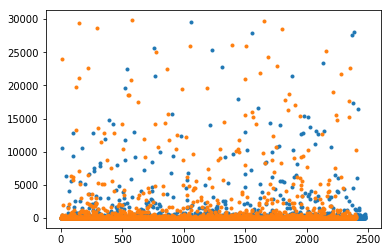

In [18]:
import matplotlib.pyplot as plt
plt.plot(np.array(reach_time_list)[np.where(reach_success_list)], '.')
plt.plot(np.array(retrieve_time_list)[np.where(retrieve_success_list)], '.')
# plt.axis([0, 400, 0, 30000])

In [ ]:
idx_succ = np.where(retrieve_success_list)[0]
retrieve_success_only=np.array(retrieve_time_list)[idx_succ]

In [ ]:
np.sqrt(np.sum(np.square(retrieve_success_only))/len(retrieve_success_only))

In [ ]:
pp = plt.hist(retrieve_success_only, bins=10)

In [34]:
len(np.where(retrieve_success_only>20000)[0])

13

In [35]:
len(retrieve_success_only)

3426

## ====================== deprecated ============================

## prepare cells

In [ ]:
gtimer = GlobalTimer.instance()
gtimer.reset()
with gtimer.block("prepare_reference_cells_ltc_full"):
    ltc_full.prepare_reference_cells(gscene)
with gtimer.block("prepare_reference_cells_ltc_effector"):
    ltc_effector.prepare_reference_cells(gscene)
with gtimer.block("prepare_reference_cells_ltc_arm_05"):
    ltc_arm_05.prepare_reference_cells(gscene)
with gtimer.block("prepare_reference_cells_ltc_arm_10"):
    ltc_arm_10.prepare_reference_cells(gscene)
print(gtimer)

In [ ]:
gscene.show_motion(Traj_reach)

## visualize

In [ ]:
vistem_list = []
for col_idx in grasp_dict['tar']:
    vistem_list.append(gscene.copy_from(ltc_effector.cell_refs[col_idx], color=(0,0,1,0.3)))

for col_idx in grasp_dict['tool']:
    vistem_list.append(gscene.copy_from(ltc_effector.cell_refs[col_idx], color=(0,1,0,0.3)))

In [ ]:
for vistem in vistem_list:
    if vistem in gscene:
        gscene.remove(vistem)

In [ ]:
vistem_list = []
for col_idx in arm_10_dict['tar']:
    vistem_list.append(gscene.copy_from(ltc_arm_10.cell_refs[col_idx], color=(0,0,1,0.3)))

for col_idx in arm_10_dict['tool']:
    vistem_list.append(gscene.copy_from(ltc_arm_10.cell_refs[col_idx], color=(0,1,0,0.3)))

In [ ]:
for vistem in vistem_list:
    if vistem in gscene:
        gscene.remove(vistem)

In [ ]:
vistem_list = []
for col_idx in full_scene_dict['tar']:
    vistem_list.append(gscene.copy_from(ltc_full.cell_refs[col_idx], color=(0,0,1,0.3)))

for col_idx in full_scene_dict['tool']:
    vistem_list.append(gscene.copy_from(ltc_full.cell_refs[col_idx], color=(0,1,0,0.3)))

In [ ]:
for vistem in vistem_list:
    if vistem in gscene:
        gscene.remove(vistem)

## grasp conversion

In [ ]:
gtimer.reset()
with gtimer.block("convert_vertices"):
    ltc_effector.convert_vertices(actor_vertinfo_list, HOME_DICT, Tref=Tref)
    ltc_effector.convert_vertices(object_vertinfo_list, HOME_DICT, Tref=Tref)
print(gtimer)

In [ ]:
vistem_list = []
for coll_idxes in ltc_effector.coll_idx_dict.values():
    for col_idx in coll_idxes:
        vistem_list.append(gscene.copy_from(ltc_effector.cell_refs[col_idx]))

In [ ]:
for vistem in vistem_list:
    if vistem in gscene:
        gscene.remove(vistem)

## scene conversion

In [ ]:
gtimer.reset()
with gtimer.block("ltc_arm_10_convert"):
    Tref_base = SE3(Tref[:3,:3], (0, 0, shoulder_height))
    ltc_arm_10.convert([gtem for gtem in gscene if gtem.collision and gtem not in gtems_robot], HOME_DICT, Tref=Tref_base)
print(gtimer)

In [ ]:
vistem_list = []
for coll_idxes in ltc_arm_10.coll_idx_dict.values():
    for col_idx in coll_idxes:
        vistem_list.append(gscene.copy_from(ltc_arm_10.cell_refs[col_idx]))

In [ ]:
for vistem in vistem_list:
    if vistem in gscene:
        gscene.remove(vistem)

## remove object

In [ ]:

pscene.remove_object(obj_pscene.oname)
for handle in handles:
    gscene.remove(handle)

In [ ]:
gscene.get_items_on_links(TOOL_LINK_BUNDLE[0]) + gscene.get_items_on_links(TOOL_LINK_BUNDLE[1])

In [ ]:
with gtimer.block("convert"):
    ltc_full.convert([gtem for gtem in gscene if gtem not in gtems_robot], crob.home_dict)

In [ ]:
print(gtimer)

In [ ]:
gscene.show_pose(crob.home_pose)

In [ ]:
# for coll_idxes in latticizer.coll_idx_dict.values():
#     for col_idx in coll_idxes:
#         gscene.copy_from(latticizer.cell_refs[col_idx])

## deprecated python ver

In [ ]:
from pkg.utils.gjk import make_point3, get_point_list, get_point_list_list, get_point_list_list_from_point_list
from pkg.utils.gjk import get_gjk_distance, get_gjk_distance_min, get_gjk_distance_all

In [ ]:
gtimer = GlobalTimer.instance()
gtimer.reset()
with gtimer.block("get_cell_vertices"):
    gscene_ref = GeometryScene(gscene.urdf_content, gscene.urdf_path, gscene.joint_names, gscene.link_names, rviz=False)
    centers = get_centers(Nwdh, L_CELL, OFFSET_ZERO).reshape((-1,3))
    cell_refs = []
    for icell, center in enumerate(centers):
        cell_refs.append(gscene_ref.create_safe(GEOTYPE.BOX, str(icell), "base_link", dims=(L_CELL,)*3, 
                                                center=center, rpy=(0,0,0), color=(1,1,1,0.2), 
                                                display=True, collision=False, fixed=True))
    cell_vertices = get_cell_vertices(centers, L_CELL)
    cell_vertices_gjk = get_point_list_list(cell_vertices)
    center_vertices_gjk = get_point_list_list(np.expand_dims(centers, axis=-2))

In [ ]:
print(gtimer)

In [ ]:
gtimer.reset()
sqrt3 = np.sqrt(3)
LCmax = L_CELL*sqrt3/2
Qdict = crob.home_dict
with gtimer.block("full"):
    for gtem in gscene:
#         if gtem in gtems_robot or not gtem.collision:
#             continue
        with gtimer.block("centers"):
            Tgtem = SE3_inv(gtem.get_tf(Qdict))
            centers_loc = np.abs(np.matmul(centers, Tgtem[:3,:3].transpose())+Tgtem[:3,3])
        if gtem.gtype == GEOTYPE.BOX and np.sum(np.abs(gtem.rpy))<1e-5:
            with gtimer.block("right box"):
                dist_list = np.max(centers_loc - np.divide(gtem.dims,2) - L_CELL, axis=-1)
                cell_idx_occupy = np.where(dist_list < 1e-3)[0]
                continue
        with gtimer.block("calc_center_dist"):
            dist_list = np.max(centers_loc - np.divide(gtem.dims,2) - LCmax, axis=-1)
            idx_candi = np.where(dist_list<0)[0]
        with gtimer.block("calc_points"):
            gtem_verts, gtem_radius = gtem.get_vertice_radius_from(Qdict)
        with gtimer.block("get_point_gjk"):
            gtem_verts_gjk = get_point_list(gtem_verts)
        with gtimer.block("get_distance_gjk"):
            cell_idx_occupy = []
            for idx in idx_candi:
                cell_candi = cell_vertices_gjk[idx]
                center_v_candi = center_vertices_gjk[idx]
                if ((get_gjk_distance(cell_candi, gtem_verts_gjk) - gtem_radius < 1e-4)):
                    cell_idx_occupy.append(idx)
#                 if ((get_gjk_distance(gtem_verts_gjk, center_v_candi) - gtem_radius - L_CELL/2 < 1e-4) or 
#                     (get_gjk_distance(cell_candi, gtem_verts_gjk) - gtem_radius < 1e-4)):
#                     cell_idx_occupy.append(idx)
print(gtimer)